In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [2]:
## NEURON PARAMTERS
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 1.
v = 0
delta_u = 1.
mu_M = 1e-5
mu_Q = 1e-5
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [3]:
## NETWORK PARAMTERS
num_visible = 9
num_hidden = 0
num_neurons = num_visible + num_hidden
num_timebins = 100000

In [4]:
## INITIALIZE WEIGHTS
weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M, 0)

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_Q, 0)

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

In [5]:
# INITIALIZE NETWORK RUN
phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

In [6]:
## GENERATE RANDOM SPIKES
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta
    
    # potential is weighted sum
    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential
    
    # firiing intensity
    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

    # generate spikes randomly as in paper
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

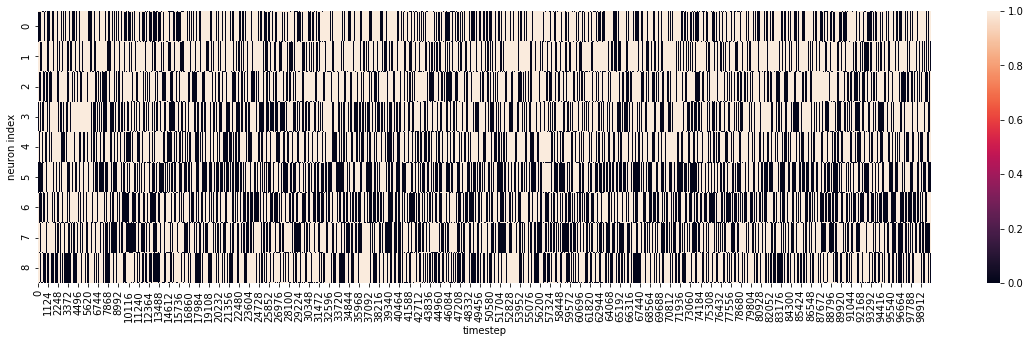

In [7]:
## HEATMAP OF GENERATED SPIKES
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(spikes)
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

In [8]:
# INITIALIZE NETWORK RUN
phi_Q = np.zeros(shape = (num_neurons, num_timebins))
rho_Q = np.zeros(shape = (num_neurons, num_timebins))
eta_Q = np.zeros(shape = (num_neurons, num_timebins))
u_Q = np.zeros(shape = (num_neurons, num_timebins))
spikes_Q = np.zeros(shape = (num_neurons, num_timebins))
spike_probs_Q = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi_Q[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta_Q[:, 0] = np.zeros(num_neurons)
u_Q[:, 0] = np.matmul(weights_Q, phi_Q[:, 0]) - eta_Q[:, 0]
rho_Q[:, 0] = rho_0 * np.exp(u_Q[:, 0])
spike_probs_Q[:, 0] = 1-np.exp(-rho_Q[:, 0])
spikes_Q[:, 0] = np.random.binomial(n = 1, p = spike_probs_Q[:, 0])

## GENERATE RANDOM SPIKES
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes_Q[:, tt - 1] - phi_Q[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes_Q[:, tt - 1] - eta_Q[:, tt - 1])

    phi_Q[:, tt] = phi_Q[:, tt - 1] + dphi
    eta_Q[:, tt] = eta_Q[:, tt - 1] + deta
    
    # potential is weighted sum
    total_potential = np.matmul(weights_M, phi_Q[:, tt]) - eta_0 * eta_Q[:, tt]
    u_Q[:, tt] = total_potential
    
    # firiing intensity
    rho_Q[:, tt] = rho_0 * np.exp((u_Q[:, tt] - v) / delta_u)

    # generate spikes randomly as in paper
    spike_probs_Q[:, tt] = 1-np.exp(-dt*rho_Q[:, tt])
    spikes_Q[:, tt] = np.random.binomial(n = 1, p = spike_probs_Q[:, tt])

In [9]:
## GENERATE STAIRCASE PATTERN
neuron_block_size = np.floor(num_visible / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

# intervals for length of "stairs"
gaussian_intervals = np.random.normal(size = 10000, loc=30, scale=5).astype(int)

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

# simulate network
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential
    
    nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
#     u[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 5.0
#     u[nonblock_idx, tt] -= 1.0

    # firing intensity
    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    # increase intensity of current stair neurons
#     rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 4.0
    
#     # decrease intensity of non-stair neurons
#     nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
#     rho[nonblock_idx, tt] = 0.05

    # generate spikes randomly as in paper
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    
    spike_probs[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] = 0.7
    spike_probs[nonblock_idx, tt] = 0.001

    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
        
    # which neurons are the new stairs?
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

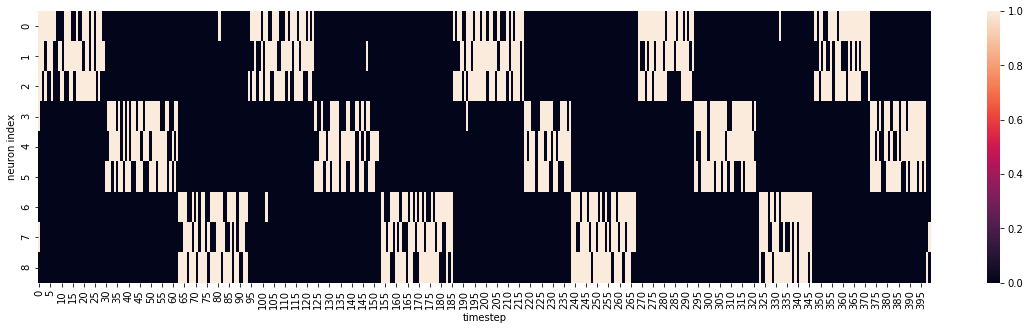

In [10]:
## HEATMAP OF GENERATED SPIKES
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(spikes[:, :400])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

In [11]:
## FUNCTIONS FOR M AND Q LIKELIHOODS AND THEIR GRADIENTS

import autograd.numpy as np

## Likelihood of M network
def LL_M(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, curr_phi) - eta_0 * curr_eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
#     curr_rho[num_visible:, :] = rho[num_visible:, :]#.copy() # set hidden rho to the values determined by Q network 
                                                               # (NOTE: this doesn't work in autograd, so I switched 
                                                               # to computing the M gradient by hand)

    LL = np.sum(np.multiply(np.log(curr_rho), curr_data) - curr_rho) * dt
    return -LL

# Data log-likelihood
def data_log_likelihood(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, curr_phi) - eta_0 * curr_eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), curr_data) - curr_rho
    LL = np.sum(individual_likelihoods[:num_visible, :]) * dt
    return LL

# M gradient by hand
def LL_M_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy() 
    
    spike_intensity_diff = spikes - curr_rho
    M_grad = -np.matmul(spike_intensity_diff, phi.T) * dt
    return M_grad


## Likelihood of Q network (only sums over hidden neurons)
def LL_Q(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes_Q) - curr_rho
    LL = np.sum(individual_likelihoods[num_visible:, :]) * dt # only sum over hidden
    return -LL

# Q gradient by hand
def LL_Q_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    spike_intensity_diff = spikes_Q - curr_rho
    Q_grad = -np.matmul(spike_intensity_diff, phi_Q.T) * dt
    return Q_grad


In [12]:
# GRADIENTS COURTESY OF AUTOGRAD
grad_LL_M = grad(LL_M)
grad_LL_Q = grad(LL_Q)

In [13]:
# INITIALIZE WEIGHTS FOR LEARNING
learned_weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_M, 0)

learned_weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_Q, 0)

In [14]:
# VALUES TO STORE OVER TRAINING
free_energy_trace = []
mean_subtract_free_energy_trace = []
LL_M_trace = []
LL_Q_trace = []

In [15]:
# LEARNING PARAMETERS
num_iters = 1000
variance_reduction_window = 10 # window of past free energies to average and subtract (reduces gradient variance)
batch_length = 200
num_batches = num_timebins / batch_length

In [16]:
## TRAINING

for iter_num in range(num_iters):
    
    for jj in range(num_batches):
        
        curr_data = spikes[:, batch_length*jj:(batch_length)*(jj+1)]
        curr_phi = phi[:, batch_length*jj:(batch_length)*(jj+1)]
        curr_eta = eta[:, batch_length*jj:(batch_length)*(jj+1)]
        curr_rho = rho[:, batch_length*jj:(batch_length)*(jj+1)]
        curr_u = u[:, batch_length*jj:(batch_length)*(jj+1)]
        curr_spike_probs = spike_probs[:, batch_length*jj:(batch_length)*(jj+1)]

        ## GET READY TO SIMULATE Q NETWORK
#         phi_Q = curr_phi.copy() #np.zeros(shape = (num_neurons, num_timebins))
#         rho_Q = curr_rho.copy() #np.zeros(shape = (num_neurons, num_timebins))
#         eta_Q = curr_eta.copy() #np.zeros(shape = (num_neurons, num_timebins))
#         u_Q = curr_u.copy() #np.zeros(shape = (num_neurons, num_timebins))
#         spikes_Q = np.zeros(shape = (num_neurons, batch_length))
#         spike_probs_Q = np.zeros(shape = (num_neurons, batch_length))

#         spike_probs_Q[:, 0] = 1-np.exp(-rho_Q[:, 0])
#         spikes_Q[:, 0] = np.random.binomial(n = 1, p = spike_probs_Q[:, 0])
#         spikes_Q[:num_visible, :] = curr_data[:num_visible, :].copy()


#         ## SIMULATE Q FOR 1,...T TO GET HIDDEN NEURONS' SPIKES
#         for tt in range(1, batch_length):

#             dphi = dt * (1 / tau) * (spikes_Q[:, tt - 1] - phi_Q[:, tt - 1])
#             deta = dt * (1 / tau_adapt) * (spikes_Q[:, tt - 1] - eta_Q[:, tt - 1])

#             phi_Q[:, tt] = phi_Q[:, tt - 1] + dphi
#             eta_Q[:, tt] = eta_Q[:, tt - 1] + deta

#             total_potential = np.matmul(learned_weights_Q, phi_Q[:, tt]) - eta_0 * eta_Q[:, tt]
#             u_Q[:, tt] = total_potential

#             rho_Q[:, tt] = rho_0 * np.exp((u_Q[:, tt] - v) / delta_u)

#             spike_probs_Q[:, tt] = 1-np.exp(-dt*rho_Q[:, tt])
#             spikes_Q[:, tt] = np.random.binomial(n = 1, p = spike_probs_Q[:, tt])

#         # Spikes of visibles are always determined by the data
#         spikes_Q[:num_visible, :] = curr_data[:num_visible, :].copy()

#         # Set hidden neuron activity to be those just simulated from Q network
#         curr_data[num_visible:, :] = spikes_Q[num_visible:, :].copy()
#         curr_phi[num_visible:, :] = phi_Q[num_visible:, :].copy()
#         curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy()
#         curr_eta[num_visible:, :] = eta_Q[num_visible:, :].copy()
#         curr_u[num_visible:, :] = u_Q[num_visible:, :].copy()
#         curr_spike_probs[num_visible:, :] = spike_probs_Q[num_visible:, :].copy()

        # DATA LOG LIKELIHOOD
        curr_data_LL = data_log_likelihood(learned_weights_M)

        ## M likelihood
        curr_LL_M = LL_M(learned_weights_M)
        LL_M_trace.append(curr_LL_M)

        # M gradient
        M_weights_gradients = grad_LL_M(learned_weights_M)
    #     M_weights_gradients = LL_M_gradient_by_hand(learned_weights_M)

        # update M weights
        learned_weights_M -= mu_M * M_weights_gradients

        # Q likelihood
        curr_LL_Q = LL_Q(learned_weights_Q)
        LL_Q_trace.append(curr_LL_Q)

        # Q gradient
        Q_weights_gradients = grad_LL_Q(learned_weights_Q)
    #     Q_weights_gradients = LL_Q_gradient_by_hand(learned_weights_Q)

        # Calculate point estimate of free energy
        free_energy = curr_LL_Q - curr_LL_M
        free_energy_trace.append(free_energy)

        # Variance reduction technique from paper (mean-subtract free energy)
        if iter_num == 0:
            curr_free_energy = 1
        else:
            curr_window_start_idx = max(-variance_reduction_window, -len(free_energy_trace))
            curr_free_energy = free_energy - np.mean(free_energy_trace[curr_window_start_idx:])
            mean_subtract_free_energy_trace.append(curr_free_energy)

        # update Q weights
        learned_weights_Q -= mu_Q * Q_weights_gradients #* curr_free_energy

        # reset connections to visible to 0
        learned_weights_Q[:num_visible, :] = 0

        # reset self-connections to 0
    #     np.fill_diagonal(learned_weights_Q, 0)

        # print progress
        if jj % 100 == 0:
            print 'iter: {}, M: {}, Q: {}, Data LL: {}'.format(iter_num, curr_LL_M, curr_LL_Q, curr_data_LL)
    #         print np.sum((learned_weights_Q - weights_Q)**2)


iter: 0, M: 1766.60043832, Q: -0.0, Data LL: -1766.60043832
iter: 0, M: 1675.81993477, Q: -0.0, Data LL: -1675.81993477
iter: 0, M: 1591.10929765, Q: -0.0, Data LL: -1591.10929765
iter: 0, M: 1514.22513318, Q: -0.0, Data LL: -1514.22513318
iter: 0, M: 1466.54295582, Q: -0.0, Data LL: -1466.54295582
iter: 1, M: 1440.77219206, Q: -0.0, Data LL: -1440.77219206
iter: 1, M: 1372.83799794, Q: -0.0, Data LL: -1372.83799794
iter: 1, M: 1327.90069123, Q: -0.0, Data LL: -1327.90069123
iter: 1, M: 1287.86561134, Q: -0.0, Data LL: -1287.86561134
iter: 1, M: 1266.52997795, Q: -0.0, Data LL: -1266.52997795
iter: 2, M: 1271.4798968, Q: -0.0, Data LL: -1271.4798968
iter: 2, M: 1215.46763095, Q: -0.0, Data LL: -1215.46763095
iter: 2, M: 1187.19890672, Q: -0.0, Data LL: -1187.19890672
iter: 2, M: 1164.09133199, Q: -0.0, Data LL: -1164.09133199
iter: 2, M: 1152.53896529, Q: -0.0, Data LL: -1152.53896529
iter: 3, M: 1168.59796272, Q: -0.0, Data LL: -1168.59796272
iter: 3, M: 1120.64292044, Q: -0.0, Data L

KeyboardInterrupt: 

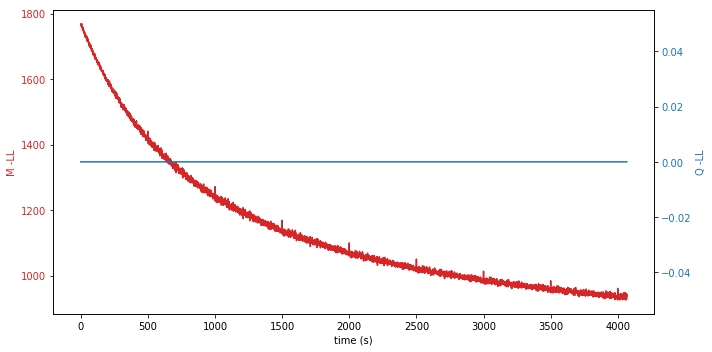

In [17]:
## PLOT LOSS OVER TIME
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('M -LL', color=color)
ax1.plot(LL_M_trace, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Q -LL', color=color)  # we already handled the x-label with ax1
ax2.plot(LL_Q_trace, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


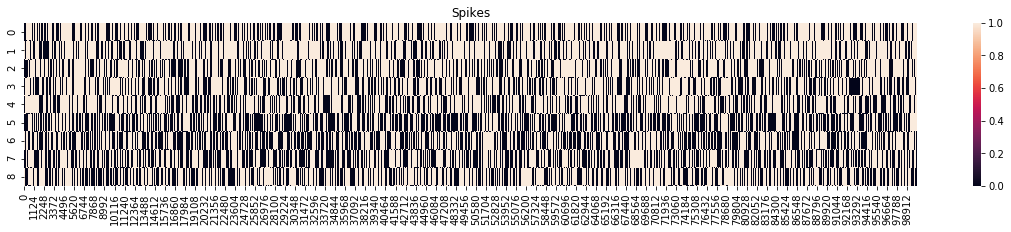

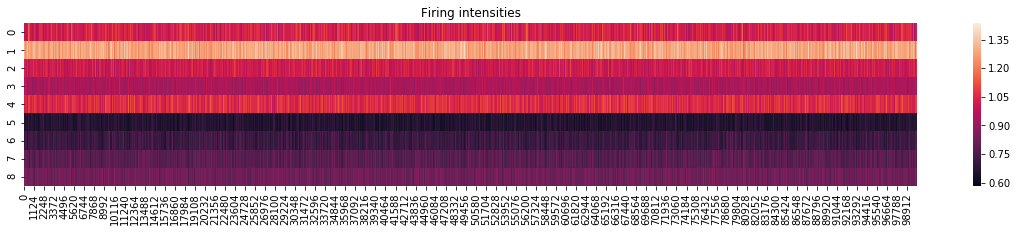

In [18]:
## HEATMAP Q SPIKES AND FIRING INTENSITIES
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_Q)
plt.title("Spikes")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(rho_Q)
plt.title("Firing intensities")
plt.show()

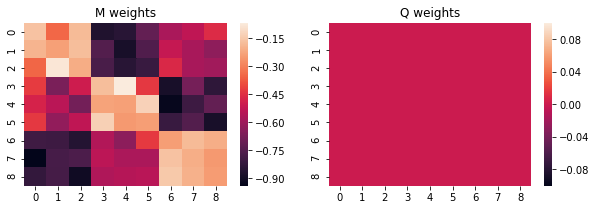

In [19]:
# np.fill_diagonal(learned_weights_M, 0)

## HEATMAP LEARNED WEIGHTS
f = plt.figure(figsize=(10, 3))
f.add_subplot(121)
plt.title("M weights")
sns.heatmap(learned_weights_M)
f.add_subplot(122)
sns.heatmap(learned_weights_Q)
plt.title("Q weights")
plt.show()

In [ ]:
## SIMULATE LEARNED M NETWORK
curr_neuron_block = 0

phi = phi.copy()
eta = eta.copy()
rho = rho.copy()
spikes = spikes.copy()
u = u.copy()
# phi[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

for tt in range(np.sum(gaussian_intervals[:3]), 1000): #num_timebins):
        
        
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential 

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
#     spike_probs[:, tt] = 1 - np.exp(-rho_0 * np.exp(np.matmul(learned_weights_M, phi[:, tt]) - eta_0 * eta[:, tt]))
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

In [ ]:
## HEATMAP SIMULATED M NETWORK
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :600]) #, xticklabels=False, yticklabels=False)
plt.ylabel("Neuron")
plt.title("Spikes")
plt.show()

# fig, ax = plt.subplots(figsize=(20, 3))
# sns.heatmap(rho[num_visible:])
# plt.show()

row_sums = np.max(rho, axis=1) #rho.sum(axis=1)
rho_row_normalized = rho / row_sums[:, np.newaxis]

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(phi[:, :600]) #, xticklabels=False, yticklabels=False)
plt.title("Firing intensity")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.show()

In [ ]:
## staircase pattern
neuron_block_size = np.floor(num_visible / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

    
for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_Q, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    rho[nonblock_idx, tt] = 0.05


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :600])
plt.title("Spikes")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(np.log(rho[:, :600]))
plt.title("Firing intensities")
plt.show()